# Releases

- Adicionando o extrator OpenFace na Análise

## Configuração

Env conda: 2way

# Análise Comparativa de Extratores de Features Faciais

Neste jupyter notebook, podemos realizar a leitura dos arquivos que contém as features extraídas da face (landmarks) e compará-los a nível de quantidade de frames com landmarks detectados entre o tipo do extrator vs variação de data augmentation.


Os augmentation foram realizados a partir do script 'FacialActionLibras/src/data/augmentation.py'

## Extratores: 

- Dlib
- Mediapipe
- OpenFace

## Augmentations:

- rot90
    - Parâmetros: k=1
- adjust_contrast
    - Parâmetros: contrast_factor=0.25
- adjust_hue
    - Parâmetros: delta=1.5
- stateless_random_brightness
    - Parâmetros: max_delta=0.95, seed=(0,0)
- adjust_jpeg_quality
    - Parâmetros: jpeg_quality==10
- adjust_brightness
    - Parâmetros: delta=0.5
- rgb_to_grayscale

## Referência:
https://www.tensorflow.org/api_docs/python/tf/image/


In [1]:
!pip install mediapy

In [2]:
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
import cv2
import utils as u
from scipy import stats

## Load Data

In [3]:
def get_name_video(string):
    new_name = string.split('/')[-1]
    return new_name

def get_files(path, extrator, aug, extension):
    """
    Descrição: Recebe um path e lista todos os arquivos e seta o extrator + tipo de augmentation
    Retorna um dataframe com todos os files concatenados de um determinado path
    """
    all_filenames = []
    df = pd.DataFrame()
    df_interno = pd.DataFrame()

    if(aug == 'original'):
        all_filenames = [i for i in glob.glob(path+'*.{}'.format(extension))]
    else:
        all_filenames = [i for i in glob.glob(path+aug+'/'+'*.{}'.format(extension))]
        
    if(len(all_filenames) > 0):
        
        for f in all_filenames:    
            df_interno = pd.read_csv(f, sep=";", index_col=None)
            if(' video_name' in df_interno.columns):
                df_interno.rename(columns={' video_name':'video_name'}, inplace=True)

            df = pd.concat([df, df_interno], axis=0)

        #df = pd.concat([pd.read_csv(f, sep=";", index_col=None) for f in all_filenames ])
        df['extractor'] = extrator
        df['aug'] = aug
        #print(df['video_name'])

        df['video_name'] = df.apply(lambda row : get_name_video(row['video_name']), axis = 1)
        df['video_name'] = df['video_name'].str.split('.', expand=True)[0]
        df['class'] = df['video_name'].str.split('_', expand=True)[1]
        
        
        
        return df[['frame', 'video_name', 'keys', 'extractor', 'aug', 'class']]
        
    



def join_files(paths, aug, extension='csv'):
    
    """
    Descrição: Recebe um dict dos paths de cada base submetida por cada extrator
    Retorna o dataframe combinado
    """
    
    df_combined = pd.DataFrame()
    
    if(aug=='original'):

        for key, value in paths.items():
            print(key, value)
            df = get_files(value, key, aug, extension)
            df_combined = pd.concat([df_combined, df], axis=0)
    
    elif(aug=='aug'):
        
        for key, value in paths.items():
            print(key, value)
            for aug in os.listdir(paths[key]):
                print(aug)
                df = get_files(value, key, aug, extension='csv')
                df_combined = pd.concat([df_combined, df], axis=0)
        
        
    return df_combined


In [4]:
#Original
inputs_orig = {
    'dlib': '../../data/processed/dlib/UCF-101-Analysis-ciclo2/',
    'mediapipe': '../../data/processed/mediapipe/UCF-101-Analysis-ciclo2/',
    'openface': '../../data/processed/openface/UCF-101-Analysis-ciclo2/UCF-101-Analysis-ciclo2/'
}

df_combined_orig = join_files(inputs_orig, aug='original', extension='csv')
df_combined_orig.shape

dlib ../../data/processed/dlib/UCF-101-Analysis-ciclo2/
mediapipe ../../data/processed/mediapipe/UCF-101-Analysis-ciclo2/
openface ../../data/processed/openface/UCF-101-Analysis-ciclo2/UCF-101-Analysis-ciclo2/


(403452, 6)

In [5]:
df_combined_orig

,frame,video_name,keys,extractor,aug,class
0,1,v_BrushingTeeth_g21_c04,"[[70, 27], [68, 48], [69, 70], [75, 92], [83, ...",dlib,original,BrushingTeeth
1,2,v_BrushingTeeth_g21_c04,"[[82, 31], [80, 49], [80, 69], [84, 87], [88, ...",dlib,original,BrushingTeeth
2,3,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 47], [76, 68], [80, 88], [86, ...",dlib,original,BrushingTeeth
3,4,v_BrushingTeeth_g21_c04,"[[79, 30], [77, 48], [77, 68], [81, 88], [86, ...",dlib,original,BrushingTeeth
4,5,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 45], [75, 65], [79, 85], [83, ...",dlib,original,BrushingTeeth
...,...,...,...,...,...,...
176,177,v_ApplyEyeMakeup_g20_c06,"[[83.8, 94.2],[84.0, 111.6],[86.0, 128.8],[89....",openface,original,ApplyEyeMakeup
177,178,v_ApplyEyeMakeup_g20_c06,"[[83.9, 95.6],[84.4, 113.2],[86.6, 130.7],[90....",openface,original,ApplyEyeMakeup
178,179,v_ApplyEyeMakeup_g20_c06,"[[84.4, 91.9],[84.3, 109.3],[86.1, 126.8],[89....",openface,original,ApplyEyeMakeup
179,180,v_ApplyEyeMakeup_g20_c06,"[[84.7, 89.3],[84.3, 106.7],[85.7, 124.4],[88....",openface,original,ApplyEyeMakeup


In [6]:
daa = df_combined_orig.loc[df_combined_orig.aug == 'original']
daa.groupby('class').agg('count')

,frame,video_name,keys,extractor,aug
class,,,,,
ApplyEyeMakeup,73074,73074,59080,73074,73074
BrushingTeeth,99015,99015,70328,99015,99015
PlayingFlute,124383,124383,54271,124383,124383
ShavingBeard,106980,106980,64151,106980,106980


In [7]:
daa = df_combined_orig.loc[df_combined_orig.aug == 'original']
daa.groupby('extractor').agg('count')

,frame,video_name,keys,aug,class
extractor,,,,,
dlib,134484,134484,45776,134484,134484
mediapipe,134484,134484,110407,134484,134484
openface,134484,134484,91647,134484,134484


In [8]:
73074+99015+124383+106980

403452

In [9]:
#Augmentation
inputs_aug = {
    'dlib': '../../data/processed/dlib/UCF-101-Analysis-augmentation-ciclo2/',
    'mediapipe': '../../data/processed/mediapipe/UCF-101-Analysis-augmentation-ciclo2/',
    'openface': '../../data/processed/openface/UCF-101-Analysis-augmentation-ciclo2/'
}

df_combined_aug = join_files(inputs_aug, aug='aug', extension='csv')
df_combined_aug.shape
        

dlib ../../data/processed/dlib/UCF-101-Analysis-augmentation-ciclo2/
rot90
adjust_contrast
log
adjust_hue
stateless_random_brightness
adjust_jpeg_quality
adjust_brightness
rgb_to_grayscale
mediapipe ../../data/processed/mediapipe/UCF-101-Analysis-augmentation-ciclo2/
rot90
adjust_contrast
log
adjust_hue
stateless_random_brightness
adjust_jpeg_quality
adjust_brightness
rgb_to_grayscale
openface ../../data/processed/openface/UCF-101-Analysis-augmentation-ciclo2/
rot90
adjust_contrast
log
adjust_hue
stateless_random_brightness
adjust_jpeg_quality
adjust_brightness
rgb_to_grayscale


(2824164, 6)

In [10]:
2824164 + 403452

3227616

In [11]:
df_combined_aug

,frame,video_name,keys,extractor,aug,class
0,1,v_BrushingTeeth_g21_c04,NaN,dlib,rot90,BrushingTeeth
1,2,v_BrushingTeeth_g21_c04,NaN,dlib,rot90,BrushingTeeth
2,3,v_BrushingTeeth_g21_c04,NaN,dlib,rot90,BrushingTeeth
3,4,v_BrushingTeeth_g21_c04,NaN,dlib,rot90,BrushingTeeth
4,5,v_BrushingTeeth_g21_c04,NaN,dlib,rot90,BrushingTeeth
...,...,...,...,...,...,...
176,177,v_ApplyEyeMakeup_g20_c06,"[[83.8, 92.9],[83.8, 110.0],[85.5, 127.1],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup
177,178,v_ApplyEyeMakeup_g20_c06,"[[83.8, 94.8],[84.1, 112.2],[86.2, 129.6],[89....",openface,rgb_to_grayscale,ApplyEyeMakeup
178,179,v_ApplyEyeMakeup_g20_c06,"[[84.4, 91.4],[84.2, 108.8],[85.9, 126.2],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup
179,180,v_ApplyEyeMakeup_g20_c06,"[[84.7, 89.1],[84.2, 106.6],[85.7, 124.2],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup


In [12]:
#Concat Augmentation and Original
        
df_combined = pd.concat([df_combined_orig, df_combined_aug], axis=0)
df_combined['na'] = np.where(df_combined['keys'].isna(), 1, 0)
df_combined.head(2)

,frame,video_name,keys,extractor,aug,class,na
0,1,v_BrushingTeeth_g21_c04,"[[70, 27], [68, 48], [69, 70], [75, 92], [83, ...",dlib,original,BrushingTeeth,0
1,2,v_BrushingTeeth_g21_c04,"[[82, 31], [80, 49], [80, 69], [84, 87], [88, ...",dlib,original,BrushingTeeth,0


In [13]:
daa = df_combined
daa.groupby(['video_name', 'aug']).agg('count')

frame  keys  extractor  \
video_name               aug                                                   
v_ApplyEyeMakeup_g01_c01 adjust_brightness              492   375        492   
                         adjust_contrast                492   299        492   
                         adjust_hue                     492   227        492   
                         adjust_jpeg_quality            492   338        492   
                         original                       492   375        492   
...                                                     ...   ...        ...   
v_ShavingBeard_g25_c06   adjust_jpeg_quality            705     1        705   
                         original                       705     6        705   
                         rgb_to_grayscale               705     0        705   
                         rot90                          705    13        705   
                         stateless_random_brightness    705     4        705   

                                                      class   na  
video_name               aug                                      
v_ApplyEyeMakeup_g01_c01 adjust_brightness              492  492  
                         adjust_contrast                492  492  
                         adjust_hue                     492  492  
                         adjust_jpeg_quality            492  492  
                         original                       492  492  
...                                                     ...  ...  
v_ShavingBeard_g25_c06   adjust_jpeg_quality            705  705  
                         original                       705  705  
                         rgb_to_grayscale               705  705  
                         rot90                          705  705  
                         stateless_random_brightness    705  705  

[4736 rows x 5 columns]

In [14]:
403452*8

3227616

In [15]:
#PRova

#df_combined['na'] = df_combined['na'].astype('category')

df_combined.loc[(df_combined.aug == 'rot90') & 
                (df_combined.extractor == 'dlib') & 
                (df_combined.video_name == 'v_ApplyEyeMakeup_g01_c01')].na.value_counts()



1    164
Name: na, dtype: int64

In [16]:
df_combined_filtro = df_combined.loc[#(df_combined.aug == 'rot90') & 
                (df_combined.extractor == 'dlib') #& 
                #(df_combined.video_name == 'v_ApplyEyeMakeup_g01_c01')
]

In [17]:
prov = df_combined_filtro.groupby(['aug', 'na', 'extractor', 'video_name'
                           ]).count().reset_index()[['aug', 'na','extractor', 'frame', 'video_name']]
df_combined_filtro.loc[(df_combined_filtro.aug == 'rot90') & 
                (df_combined_filtro.extractor == 'dlib') & 
                (df_combined_filtro.video_name == 'v_ApplyEyeMakeup_g01_c01')]

,frame,video_name,keys,extractor,aug,class,na
0,1,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
1,2,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
2,3,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
3,4,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
4,5,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
...,...,...,...,...,...,...,...
159,160,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
160,161,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
161,162,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1
162,163,v_ApplyEyeMakeup_g01_c01,NaN,dlib,rot90,ApplyEyeMakeup,1


In [18]:
df_combined['class'].value_counts()

PlayingFlute      995064
ShavingBeard      855840
BrushingTeeth     792120
ApplyEyeMakeup    584592
Name: class, dtype: int64

In [19]:
print('Quantidade de Frames [Dlib]: '+str(df_combined.loc[df_combined.extractor == 'dlib'].shape))
print('Quantidade de Frames [Mediapipe]: '+str(df_combined.loc[df_combined.extractor == 'mediapipe'].shape))
print('Quantidade de Frames [OpenFace]: '+str(df_combined.loc[df_combined.extractor == 'openface'].shape))

Quantidade de Frames [Dlib]: (1075872, 7)
Quantidade de Frames [Mediapipe]: (1075872, 7)
Quantidade de Frames [OpenFace]: (1075872, 7)


In [20]:
1075872*3

3227616

# Por Augmentation

In [21]:
df_combined.groupby(['extractor', 'aug']).size().reset_index(name='counts')

,extractor,aug,counts
0,dlib,adjust_brightness,134484
1,dlib,adjust_contrast,134484
2,dlib,adjust_hue,134484
3,dlib,adjust_jpeg_quality,134484
4,dlib,original,134484
5,dlib,rgb_to_grayscale,134484
6,dlib,rot90,134484
7,dlib,stateless_random_brightness,134484
8,mediapipe,adjust_brightness,134484
9,mediapipe,adjust_contrast,134484


In [22]:
label_mediapipe = 'mediapipe'
label_dlib = 'dlib'
label_openface = 'openface'

print("----- Description -----")
mdnna = (len(df_combined.loc[(df_combined.extractor == label_mediapipe) & (df_combined['keys'].notna())])/len(df_combined))
mdna = (len(df_combined.loc[(df_combined.extractor == label_mediapipe) & (df_combined['keys'].isna())])/len(df_combined))
dbnna = (len(df_combined.loc[(df_combined.extractor == label_dlib) & (df_combined['keys'].notna())])/len(df_combined))
dbna = (len(df_combined.loc[(df_combined.extractor == label_dlib) & (df_combined['keys'].isna())])/len(df_combined))
ofnna = (len(df_combined.loc[(df_combined.extractor == label_openface) & (df_combined['keys'].notna())])/len(df_combined))
ofna = (len(df_combined.loc[(df_combined.extractor == label_openface) & (df_combined['keys'].isna())])/len(df_combined))


print("Porcentagem frames com landmarks detectados Mediapipe: {:.2f}%".format(mdnna))
print("Porcentagem frames com landmarks NÃO detectados Mediapipe: {:.2f}%".format(mdna))
print("Porcentagem frames com landmarks detectados Dlib: {:.2f}%".format(dbnna))
print("Porcentagem frames com landmarks NÃO detectados Dlib: {:.2f}%".format(dbna))
print("Porcentagem frames com landmarks detectados Dlib: {:.2f}%".format(ofnna))
print("Porcentagem frames com landmarks NÃO detectados Dlib: {:.2f}%".format(ofna))
    

----- Description -----
Porcentagem frames com landmarks detectados Mediapipe: 0.20%
Porcentagem frames com landmarks NÃO detectados Mediapipe: 0.13%
Porcentagem frames com landmarks detectados Dlib: 0.08%
Porcentagem frames com landmarks NÃO detectados Dlib: 0.25%
Porcentagem frames com landmarks detectados Dlib: 0.15%
Porcentagem frames com landmarks NÃO detectados Dlib: 0.18%


In [23]:
df_combined.groupby(['aug', 'na', 'extractor']).count().reset_index()[['aug', 'na','extractor', 'frame']]

,aug,na,extractor,frame
0,adjust_brightness,0,dlib,40717
1,adjust_brightness,0,mediapipe,87676
2,adjust_brightness,0,openface,66139
3,adjust_brightness,1,dlib,93767
4,adjust_brightness,1,mediapipe,46808
5,adjust_brightness,1,openface,68345
6,adjust_contrast,0,dlib,35081
7,adjust_contrast,0,mediapipe,75504
8,adjust_contrast,0,openface,57887
9,adjust_contrast,1,dlib,99403


In [24]:
df_combined.groupby(['aug', 'na', 'extractor']).count().reset_index()[['aug', 'na','extractor', 'frame']].frame.sum()

3227616

In [25]:
df_combined.head(3)

,frame,video_name,keys,extractor,aug,class,na
0,1,v_BrushingTeeth_g21_c04,"[[70, 27], [68, 48], [69, 70], [75, 92], [83, ...",dlib,original,BrushingTeeth,0
1,2,v_BrushingTeeth_g21_c04,"[[82, 31], [80, 49], [80, 69], [84, 87], [88, ...",dlib,original,BrushingTeeth,0
2,3,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 47], [76, 68], [80, 88], [86, ...",dlib,original,BrushingTeeth,0


In [26]:
df_combined.loc[df_combined.aug == 'adjust_brightness'][['frame', 'video_name', 'extractor', 'aug','class','na']].to_csv("ciclo2.csv", sep=',', index=False)

In [27]:
def plt_bar_extract(df_combined, extractor):
    fig = plt.figure(figsize=(14,8))
    count = 1
    colors = ['green',"red", 'blue']

    df = df_combined.loc[(df_combined['extractor'] == extractor)]
    ax = sns.countplot(x="aug", hue="na", data=df, palette=colors)
    ax.set(ylabel='Total of Frames', title=extractor)
    for c in ax.containers:
        labels = [f'{w/len(df.index)*len(df.aug.unique())*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    plt.xticks(rotation=20)

    
def plt_bar_extract_na(df_combined, na):
    fig = plt.figure(figsize=(14,8))
    count = 1
    colors = ['green', "red", 'blue']

    df = df_combined.loc[(df_combined['na'] == na)].reset_index()
    ax = sns.countplot(x="aug", hue="extractor", data=df, palette=colors)
    ax.set(ylabel='Total of Frames', title='Quantidade de frames com landmarks retornados (%)')
    idx_extractor=0
    for c in ax.containers:
        qt_extractores = len(df_combined.extractor.unique())
        qt_aug = len(df_combined.aug.unique())
        
        #labels = [f'{w/len(df.index)*len(df.aug.unique())*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        labels = [f'{w/((len(df_combined)/qt_extractores)/qt_aug)*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
        idx_extractor=idx_extractor+1
        
    plt.xticks(rotation=20)

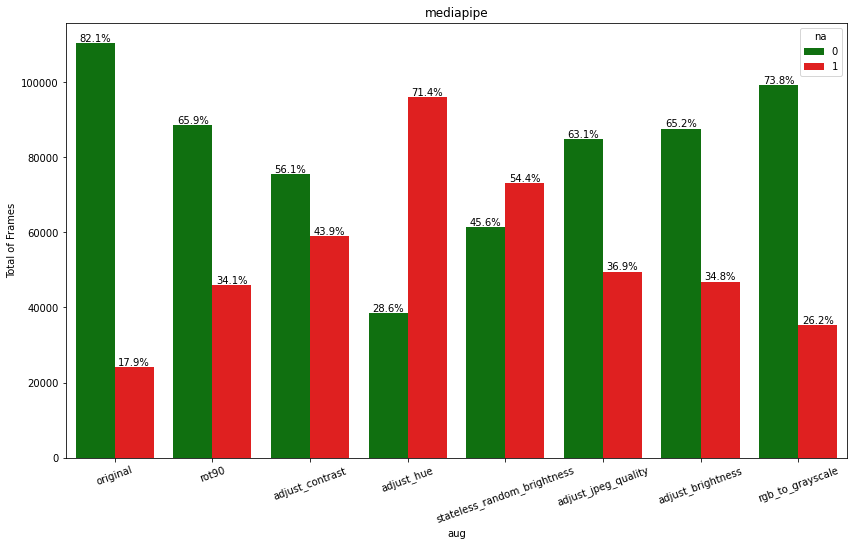

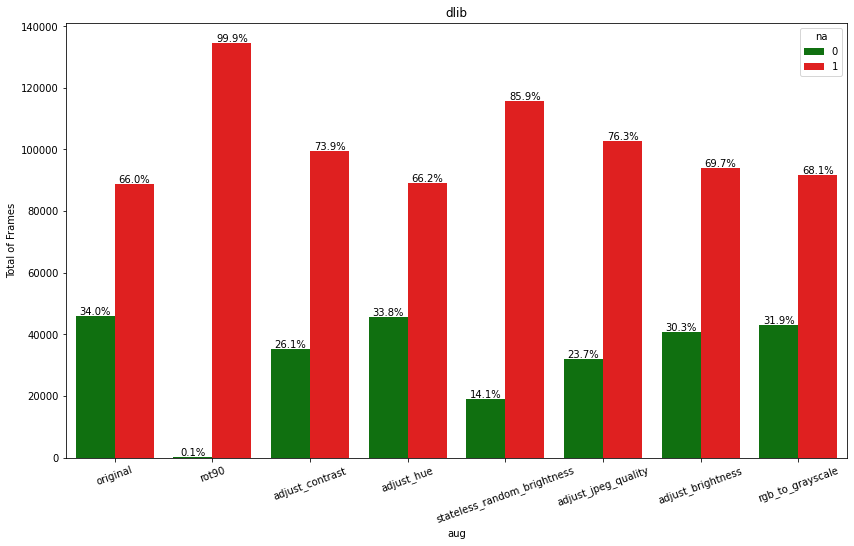

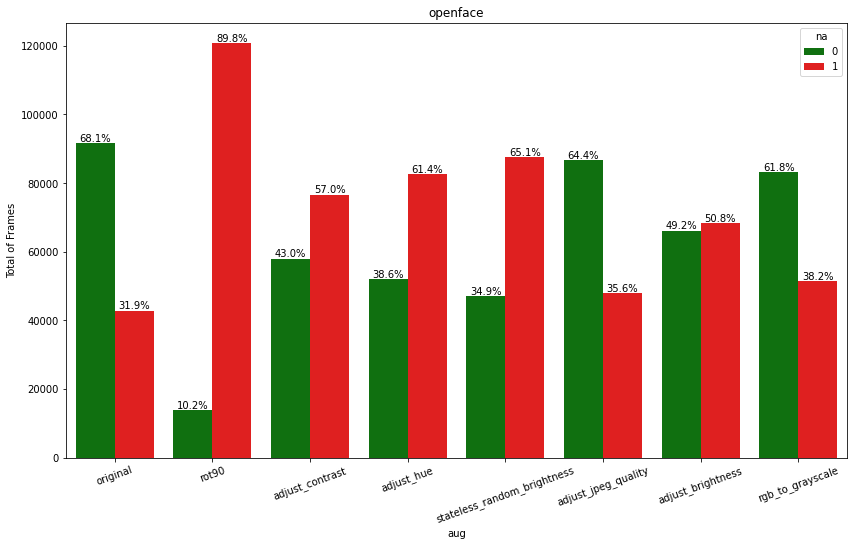

In [28]:
plt_bar_extract(df_combined,  'mediapipe')
plt_bar_extract(df_combined,  'dlib')
plt_bar_extract(df_combined,  'openface')

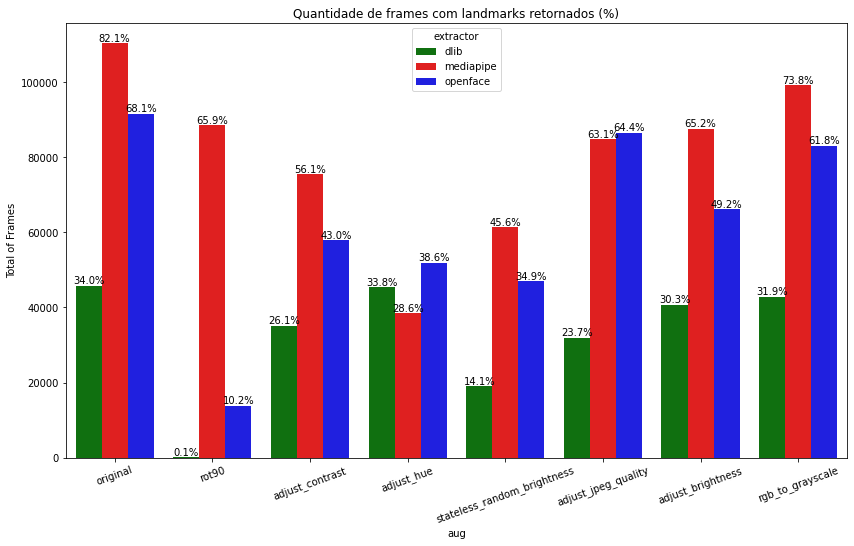

In [29]:
plt_bar_extract_na(df_combined,  0)

In [30]:
dados = df_combined.groupby(['extractor', 'aug', 'na']).size().reset_index(name='counts')
dados.loc[dados.na == 1]

,extractor,aug,na,counts
1,dlib,adjust_brightness,1,93767
3,dlib,adjust_contrast,1,99403
5,dlib,adjust_hue,1,89030
7,dlib,adjust_jpeg_quality,1,102592
9,dlib,original,1,88708
11,dlib,rgb_to_grayscale,1,91643
13,dlib,rot90,1,134353
15,dlib,stateless_random_brightness,1,115522
17,mediapipe,adjust_brightness,1,46808
19,mediapipe,adjust_contrast,1,58980


In [31]:
print(dados.loc[dados.na == 1].counts.sum())
print(dados.loc[dados.na == 0].counts.sum())

1822489
1405127


In [32]:
1822489-1822720

-231

In [33]:
1405127-1404896

231

In [34]:
df_combined

,frame,video_name,keys,extractor,aug,class,na
0,1,v_BrushingTeeth_g21_c04,"[[70, 27], [68, 48], [69, 70], [75, 92], [83, ...",dlib,original,BrushingTeeth,0
1,2,v_BrushingTeeth_g21_c04,"[[82, 31], [80, 49], [80, 69], [84, 87], [88, ...",dlib,original,BrushingTeeth,0
2,3,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 47], [76, 68], [80, 88], [86, ...",dlib,original,BrushingTeeth,0
3,4,v_BrushingTeeth_g21_c04,"[[79, 30], [77, 48], [77, 68], [81, 88], [86, ...",dlib,original,BrushingTeeth,0
4,5,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 45], [75, 65], [79, 85], [83, ...",dlib,original,BrushingTeeth,0
...,...,...,...,...,...,...,...
176,177,v_ApplyEyeMakeup_g20_c06,"[[83.8, 92.9],[83.8, 110.0],[85.5, 127.1],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup,0
177,178,v_ApplyEyeMakeup_g20_c06,"[[83.8, 94.8],[84.1, 112.2],[86.2, 129.6],[89....",openface,rgb_to_grayscale,ApplyEyeMakeup,0
178,179,v_ApplyEyeMakeup_g20_c06,"[[84.4, 91.4],[84.2, 108.8],[85.9, 126.2],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup,0
179,180,v_ApplyEyeMakeup_g20_c06,"[[84.7, 89.1],[84.2, 106.6],[85.7, 124.2],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup,0


# Diferença do Augmentation para a base Original

In [35]:
def diff_calcule(df_combined):
    
    df_diff_ofc = pd.DataFrame()
    
    for i in df_combined['extractor'].unique():
        df = df_combined.loc[(df_combined['extractor'] == i)]
        df_diff = pd.crosstab(df['aug'],df['na']).apply(lambda r: r/r.sum(), axis=1).reset_index()

        ## Diferença de porcentagem
        ref_origin =  df_diff.loc[df_diff.aug == 'original'].reset_index().at[0,0] #index, col
        print(ref_origin)

        df_diff['diff_original'] = df_diff[0] - ref_origin
        df_diff['extractor'] = i
        df_diff.rename(columns={0:'notna'}, inplace=True)
        del df_diff[1]
        
        df_diff_ofc = pd.concat([df_diff_ofc, df_diff], axis=0)
    
    return df_diff_ofc

In [36]:
df_diff = diff_calcule(df_combined)
df_diff

0.3403824990333423
0.8209675500431278
0.6814714018024449


na,aug,notna,diff_original,extractor
0,adjust_brightness,0.302765,-0.037618,dlib
1,adjust_contrast,0.260856,-0.079526,dlib
2,adjust_hue,0.337988,-0.002394,dlib
3,adjust_jpeg_quality,0.237143,-0.103239,dlib
4,original,0.340382,0.000000,dlib
5,rgb_to_grayscale,0.318558,-0.021824,dlib
6,rot90,0.000974,-0.339408,dlib
7,stateless_random_brightness,0.140998,-0.199384,dlib
0,adjust_brightness,0.651944,-0.169024,mediapipe
1,adjust_contrast,0.561435,-0.259533,mediapipe


In [37]:
df_diff.reset_index().copy()

na,index,aug,notna,diff_original,extractor
0,0,adjust_brightness,0.302765,-0.037618,dlib
1,1,adjust_contrast,0.260856,-0.079526,dlib
2,2,adjust_hue,0.337988,-0.002394,dlib
3,3,adjust_jpeg_quality,0.237143,-0.103239,dlib
4,4,original,0.340382,0.000000,dlib
5,5,rgb_to_grayscale,0.318558,-0.021824,dlib
6,6,rot90,0.000974,-0.339408,dlib
7,7,stateless_random_brightness,0.140998,-0.199384,dlib
8,0,adjust_brightness,0.651944,-0.169024,mediapipe
9,1,adjust_contrast,0.561435,-0.259533,mediapipe


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'adjust_brightness'),
  Text(1, 0, 'adjust_contrast'),
  Text(2, 0, 'adjust_hue'),
  Text(3, 0, 'adjust_jpeg_quality'),
  Text(4, 0, 'original'),
  Text(5, 0, 'rgb_to_grayscale'),
  Text(6, 0, 'rot90'),
  Text(7, 0, 'stateless_random_brightness')])

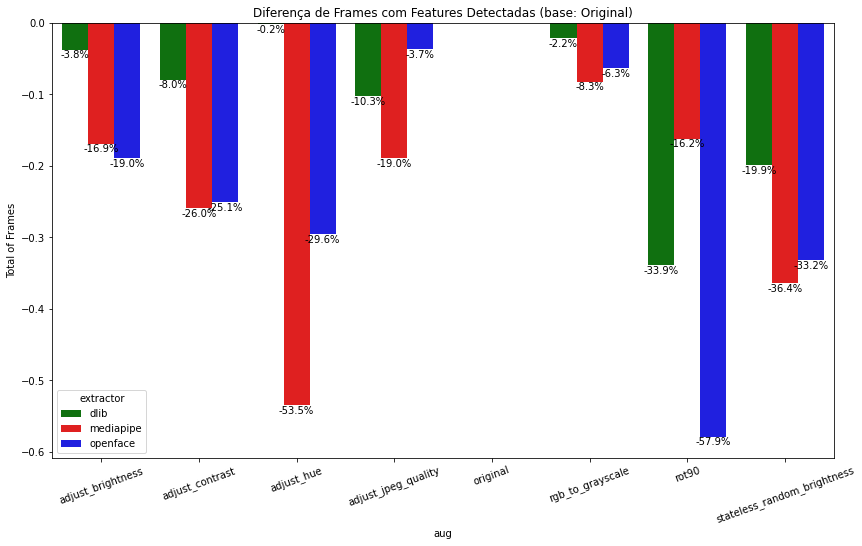

In [38]:
fig = plt.figure(figsize=(14,8))
count = 1
colors = ['green', "red", 'blue']
ax = sns.barplot(x="aug", y="diff_original", hue="extractor", data=df_diff, palette=colors)
ax.set(ylabel='Total of Frames', title='Diferença de Frames com Features Detectadas (base: Original)')

for c in ax.containers:
    labels = [f'{w*100:0.1f}%' if (w := v.get_height()) < 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
    
plt.xticks(rotation=20)



## Análise dos Gráficos

Ao considerar a diferença de quantidade de frames com landmarks detectados entre a base original e as variações de data augmentation, é possível perceber que o extrator Mediapipe é mais sensível ao ajuste de hue (matiz/tonalidade), redução de brilho e ajuste de contraste. 

Já o Dlib é muito sensível quando os dados estão rotacionados a 90° e podemos considerar que, ao observar os dados analisados, o Dlib é pouco sensível a dados com ajuste de hue (matiz/tonalidade) e escala de cinza.



In [39]:
def get_total_frames_unit(video, ext, aug, total_frames):
    return total_frames.loc[(total_frames.video_name == video) & 
                            (total_frames.extractor == ext) & 
                            (total_frames.aug == aug)].reset_index().at[0,'total_frames'] #index, col

In [40]:
df_combined

,frame,video_name,keys,extractor,aug,class,na
0,1,v_BrushingTeeth_g21_c04,"[[70, 27], [68, 48], [69, 70], [75, 92], [83, ...",dlib,original,BrushingTeeth,0
1,2,v_BrushingTeeth_g21_c04,"[[82, 31], [80, 49], [80, 69], [84, 87], [88, ...",dlib,original,BrushingTeeth,0
2,3,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 47], [76, 68], [80, 88], [86, ...",dlib,original,BrushingTeeth,0
3,4,v_BrushingTeeth_g21_c04,"[[79, 30], [77, 48], [77, 68], [81, 88], [86, ...",dlib,original,BrushingTeeth,0
4,5,v_BrushingTeeth_g21_c04,"[[77, 28], [75, 45], [75, 65], [79, 85], [83, ...",dlib,original,BrushingTeeth,0
...,...,...,...,...,...,...,...
176,177,v_ApplyEyeMakeup_g20_c06,"[[83.8, 92.9],[83.8, 110.0],[85.5, 127.1],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup,0
177,178,v_ApplyEyeMakeup_g20_c06,"[[83.8, 94.8],[84.1, 112.2],[86.2, 129.6],[89....",openface,rgb_to_grayscale,ApplyEyeMakeup,0
178,179,v_ApplyEyeMakeup_g20_c06,"[[84.4, 91.4],[84.2, 108.8],[85.9, 126.2],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup,0
179,180,v_ApplyEyeMakeup_g20_c06,"[[84.7, 89.1],[84.2, 106.6],[85.7, 124.2],[88....",openface,rgb_to_grayscale,ApplyEyeMakeup,0


## [Fix] Zero counts solved

In [41]:
#Considerando valores zerados
#https://github.com/pandas-dev/pandas/issues/8559

df_combined['na'] = df_combined['na'].astype('category')

df_combined.loc[(df_combined.aug == 'rot90') & 
                (df_combined.extractor == 'dlib') & 
                (df_combined.video_name == 'v_ApplyEyeMakeup_g01_c01')].na.value_counts()

1    164
0      0
Name: na, dtype: int64

In [42]:
df_combined.shape

(3227616, 7)

In [43]:
#Na análise anterior não era considerados v[ídeos que tinham todo seu corpo com frme retornado]
#tenho que ter uma linha 
#v_ApplyEyeMakeup_g01_c01	dlib	rot90	ApplyEyeMakeup	0	0	164	0.0

In [44]:
s = pd.Series(['a','b','a','c','d','c'])
count_str = s[s.isin(['a','u'])].value_counts()
print(count_str)

a    2
dtype: int64


In [45]:
count_cat = s.astype('category')[s.isin(['a','u'])].value_counts()
print(count_cat)

a    2
b    0
c    0
d    0
dtype: int64


In [46]:
total_frames = df_combined.groupby(['video_name', 'extractor', 'aug']).size().reset_index(name='total_frames')
df_diff_unit = df_combined.groupby(['video_name', 'extractor', 'aug', 'na']).size().reset_index(name='counts_NAs')

display(df_diff_unit.loc[#(df_diff_unit.aug == 'rot90') & 
                #(df_diff_unit.extractor == 'dlib') & 
                (df_diff_unit.video_name == 'v_ApplyEyeMakeup_g01_c01')])

#continua

,video_name,extractor,aug,na,counts_NAs
0,v_ApplyEyeMakeup_g01_c01,dlib,adjust_brightness,0,64
1,v_ApplyEyeMakeup_g01_c01,dlib,adjust_brightness,1,100
2,v_ApplyEyeMakeup_g01_c01,dlib,adjust_contrast,0,42
3,v_ApplyEyeMakeup_g01_c01,dlib,adjust_contrast,1,122
4,v_ApplyEyeMakeup_g01_c01,dlib,adjust_hue,0,63
5,v_ApplyEyeMakeup_g01_c01,dlib,adjust_hue,1,101
6,v_ApplyEyeMakeup_g01_c01,dlib,adjust_jpeg_quality,0,40
7,v_ApplyEyeMakeup_g01_c01,dlib,adjust_jpeg_quality,1,124
8,v_ApplyEyeMakeup_g01_c01,dlib,original,0,64
9,v_ApplyEyeMakeup_g01_c01,dlib,original,1,100


In [47]:
#CASO
#12	v_ApplyEyeMakeup_g01_c01	dlib	rot90	0	0
#13	v_ApplyEyeMakeup_g01_c01	dlib	rot90	1	164

In [48]:
# CASO
gg = df_diff_unit.groupby(['video_name', 'extractor']).sum()
gg['counts_NAs'] = gg['counts_NAs'].astype(str)
gg = gg.groupby(['video_name', 'counts_NAs'])['counts_NAs'].count().reset_index(name='total')
gg.loc[gg.total != 3]

,video_name,counts_NAs,total


In [49]:
df_diff_unit['total_frames'] = df_diff_unit.apply(lambda x: get_total_frames_unit(x['video_name'], x['extractor'], x['aug'], total_frames), axis=1)
df_diff_unit['percent_NAs'] = df_diff_unit['counts_NAs']/df_diff_unit['total_frames']
df_diff_unit['percent_NAs'] = round(df_diff_unit['percent_NAs']*100, 2)

df_diff_unit.loc[(df_diff_unit.extractor == 'dlib') &
((df_diff_unit.video_name == 'v_ApplyEyeMakeup_g01_c02') |
(df_diff_unit.video_name == 'v_ApplyEyeMakeup_g01_c01') |
(df_diff_unit.video_name == 'v_PlayingFlute_g05_c04') |
(df_diff_unit.video_name == 'v_ShavingBeard_g16_c02'))]


,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
0,v_ApplyEyeMakeup_g01_c01,dlib,adjust_brightness,0,64,164,39.02
1,v_ApplyEyeMakeup_g01_c01,dlib,adjust_brightness,1,100,164,60.98
2,v_ApplyEyeMakeup_g01_c01,dlib,adjust_contrast,0,42,164,25.61
3,v_ApplyEyeMakeup_g01_c01,dlib,adjust_contrast,1,122,164,74.39
4,v_ApplyEyeMakeup_g01_c01,dlib,adjust_hue,0,63,164,38.41
...,...,...,...,...,...,...,...
25211,v_ShavingBeard_g16_c02,dlib,rgb_to_grayscale,1,0,264,0.00
25212,v_ShavingBeard_g16_c02,dlib,rot90,0,0,264,0.00
25213,v_ShavingBeard_g16_c02,dlib,rot90,1,264,264,100.00
25214,v_ShavingBeard_g16_c02,dlib,stateless_random_brightness,0,0,264,0.00


In [50]:
# CASO
gg = df_diff_unit[['video_name', 
                   'extractor', 
                   'aug', 
                   'na', 
                   'percent_NAs']].groupby(['video_name', 'extractor', 'aug']).sum().reset_index()

gg['percent_NAs'] = gg['percent_NAs'].astype(float)
gg.loc[gg.percent_NAs != 100]
#gg['counts_notna'] = gg['counts_notna'].astype(str)
#gg = gg.groupby(['video_name', 'counts_notna'])['counts_notna'].count().reset_index(name='total')
#gg.loc[gg.total != 3]


,video_name,extractor,aug,percent_NAs
11566,v_ShavingBeard_g09_c01,openface,rot90,100.01


In [51]:
# CASO
gg = gg.groupby(['video_name', 'aug', 'percent_NAs'])['percent_NAs'].count().reset_index(name='total')
gg.loc[gg.total != 3]

,video_name,aug,percent_NAs,total
3854,v_ShavingBeard_g09_c01,rot90,100.00,2
3855,v_ShavingBeard_g09_c01,rot90,100.01,1


In [52]:
gg.percent_NAs.value_counts()

100.00    4736
100.01       1
Name: percent_NAs, dtype: int64

In [53]:
# CASO
df_diff_unit.loc[df_diff_unit.video_name == 'v_ShavingBeard_g09_c01']

,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
23088,v_ShavingBeard_g09_c01,dlib,adjust_brightness,0,0,160,0.00
23089,v_ShavingBeard_g09_c01,dlib,adjust_brightness,1,160,160,100.00
23090,v_ShavingBeard_g09_c01,dlib,adjust_contrast,0,0,160,0.00
23091,v_ShavingBeard_g09_c01,dlib,adjust_contrast,1,160,160,100.00
23092,v_ShavingBeard_g09_c01,dlib,adjust_hue,0,0,160,0.00
23093,v_ShavingBeard_g09_c01,dlib,adjust_hue,1,160,160,100.00
23094,v_ShavingBeard_g09_c01,dlib,adjust_jpeg_quality,0,0,160,0.00
23095,v_ShavingBeard_g09_c01,dlib,adjust_jpeg_quality,1,160,160,100.00
23096,v_ShavingBeard_g09_c01,dlib,original,0,0,160,0.00
23097,v_ShavingBeard_g09_c01,dlib,original,1,160,160,100.00


In [54]:
# MUDANÇA ADD METRIC VIDEO ERROR PROPORCIONAL
df_diff_unit = df_diff_unit.loc[df_diff_unit.na == 1].reset_index()

In [55]:
print(df_diff_unit.loc[df_diff_unit.na == 0].shape)
print(df_diff_unit.loc[df_diff_unit.na == 1].shape)

(0, 8)
(14208, 8)


In [56]:
df_diff_unit.loc[df_diff_unit.total_frames == df_diff_unit.counts_NAs]

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
6,13,v_ApplyEyeMakeup_g01_c01,dlib,rot90,1,164,164,100.0
30,61,v_ApplyEyeMakeup_g01_c02,dlib,rot90,1,123,123,100.0
54,109,v_ApplyEyeMakeup_g01_c03,dlib,rot90,1,259,259,100.0
64,129,v_ApplyEyeMakeup_g01_c03,openface,adjust_brightness,1,259,259,100.0
78,157,v_ApplyEyeMakeup_g01_c04,dlib,rot90,1,235,235,100.0
...,...,...,...,...,...,...,...,...
14201,28403,v_ShavingBeard_g25_c06,openface,adjust_contrast,1,235,235,100.0
14202,28405,v_ShavingBeard_g25_c06,openface,adjust_hue,1,235,235,100.0
14204,28409,v_ShavingBeard_g25_c06,openface,original,1,235,235,100.0
14205,28411,v_ShavingBeard_g25_c06,openface,rgb_to_grayscale,1,235,235,100.0


In [57]:
print(df_diff_unit.loc[df_diff_unit.percent_NAs == 1].shape)
print(df_diff_unit.loc[(df_diff_unit.percent_NAs == 50) & (df_diff_unit.na == 1)].shape)

(5, 8)
(4, 8)


In [58]:
df_diff_unit.loc[(df_diff_unit.percent_NAs == 50) & (df_diff_unit.na == 0)]

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs


### [FIX] Representa 5% dos dados

In [59]:
print(df_diff_unit.percent_NAs.min())
print(df_diff_unit.percent_NAs.max())

0.0
100.0


In [60]:
df_diff_unit.na.value_counts()

1    14208
0        0
Name: na, dtype: int64

In [61]:
df_diff_unit.loc[(df_diff_unit.aug == 'rot90') & 
                (df_diff_unit.extractor == 'dlib') & 
                (df_diff_unit.video_name == 'v_ApplyEyeMakeup_g01_c01')]

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
6,13,v_ApplyEyeMakeup_g01_c01,dlib,rot90,1,164,164,100.0


In [62]:
#df_diff_unit.groupby(['video_name', 'extractor', 'aug', 'na']).agg('count')

df_diff_unit

#data_stats.to_csv("../data/outputs/Videos-Emely-Extra/predicts_squeezenet/f1_estimation_stats.csv", sep=',', index=False)

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
0,1,v_ApplyEyeMakeup_g01_c01,dlib,adjust_brightness,1,100,164,60.98
1,3,v_ApplyEyeMakeup_g01_c01,dlib,adjust_contrast,1,122,164,74.39
2,5,v_ApplyEyeMakeup_g01_c01,dlib,adjust_hue,1,101,164,61.59
3,7,v_ApplyEyeMakeup_g01_c01,dlib,adjust_jpeg_quality,1,124,164,75.61
4,9,v_ApplyEyeMakeup_g01_c01,dlib,original,1,100,164,60.98
...,...,...,...,...,...,...,...,...
14203,28407,v_ShavingBeard_g25_c06,openface,adjust_jpeg_quality,1,234,235,99.57
14204,28409,v_ShavingBeard_g25_c06,openface,original,1,235,235,100.00
14205,28411,v_ShavingBeard_g25_c06,openface,rgb_to_grayscale,1,235,235,100.00
14206,28413,v_ShavingBeard_g25_c06,openface,rot90,1,224,235,95.32


<Figure size 1008x576 with 0 Axes>

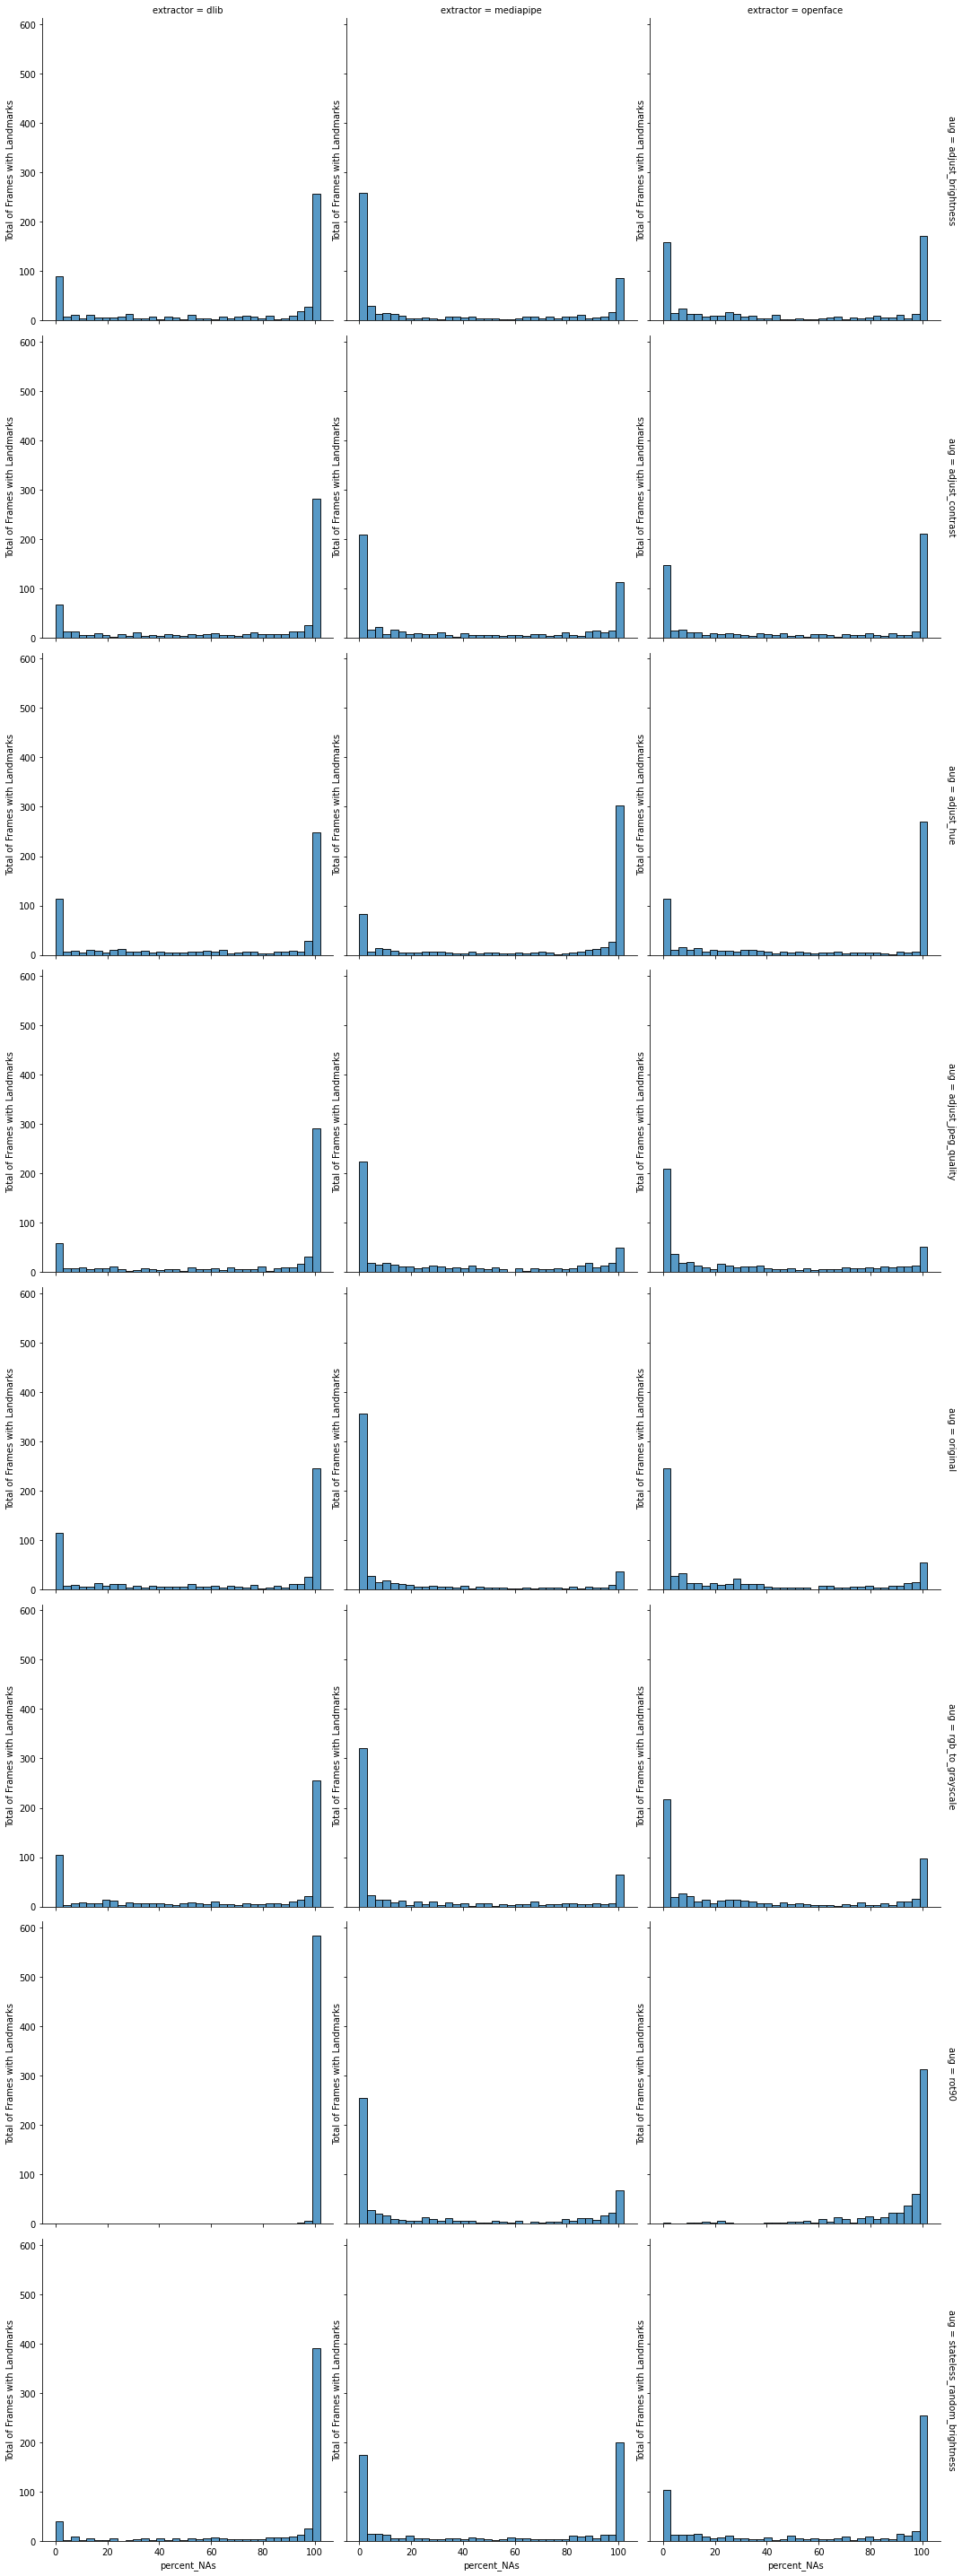

In [63]:
fig = plt.figure(figsize=(14,8))

ax =  sns.displot(
    df_diff_unit, x="percent_NAs", col="extractor", row="aug",
    binwidth=3, height=5, facet_kws=dict(margin_titles=True),
)
ax.set(ylabel='Total of Frames with Landmarks')


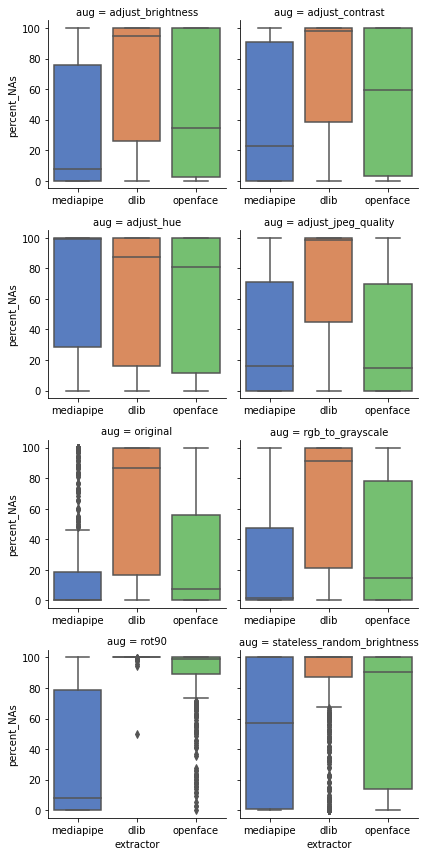

In [64]:
g = sns.FacetGrid(df_diff_unit, col='aug',col_wrap=2)
#                                               change this to 4 ^
g.map(sns.boxplot,'extractor','percent_NAs',palette='muted', order=['mediapipe', 'dlib', 'openface'])
for ax in g.axes.flatten(): 
    ax.tick_params(labelbottom=True)
plt.tight_layout()
plt.show()

In [65]:
#Ao analisar a figura acima, temos que para o dataset original quando submetido ao extrator Dlib, há uma concentração de outliers considerável abaixo 70%, ou seja, de vídeos em que a porcentagem da quantidade de seus frames com landmarks detectados foi menor que 70%.

#Embora o Mediapipe tenha uma quantidade de frames detectados muito maior que o Dlib. Ao avaliar por vídeo (a unidade) e realizar um processamento de forma que para cada linha (vídeo) para encontrar a porcentagem de frames detectados nesse mesmo vídeo. Podemos ver que no Dlib, há um número considerável de outliers abaixo de 70%, isto é, há um número considerável de vídeos específicos em que o total de seus frames com landmarks detectados são abaixo de 70%.

#Resumindo, mas não concluindo. Talvez se não existissem "alguns vídeos específicos" o Dlib pode melhorar bastante a detecção de landmarks. Hipótese: Talvez "esses vídeos específicos" que tem 70% do seu corpo sem landmarks detectados, seja pelo fato de terem alguma característica em comum que deixa o Dlib sensível (como a distância da câmera ou tamanho do crop da face).

#Então vamos analisar alguns desses outliers?

#Validado (motivos):

#Ordem
#<=0.70 [0:100]
#whis=np.inf,


#16% dos dados podem ser considerados outliers...
#Qual o valor default para delimitar o que é um outlier ou não

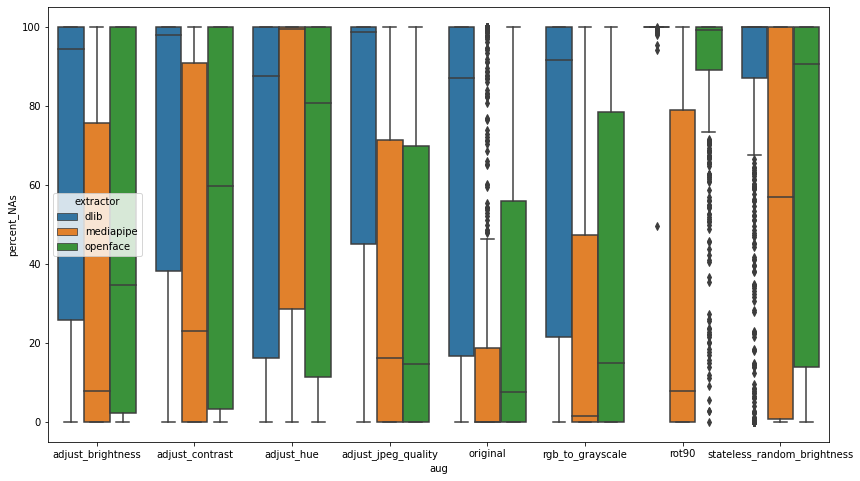

In [66]:
fig = plt.figure(figsize=(14,8))

ax = sns.boxplot(x="aug", y="percent_NAs", data=df_diff_unit, hue="extractor")
#ax = sns.stripplot(x="aug", y="percent_notna", data=df_diff_unit, color=".3", hue="extractor")

/home/jms2/anaconda3/envs/2way/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/jms2/anaconda3/envs/2way/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


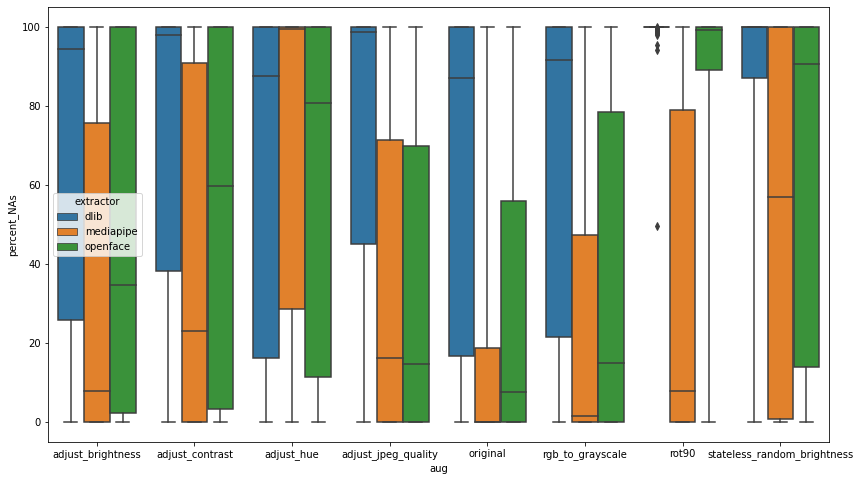

In [67]:
fig = plt.figure(figsize=(14,8))

ax = sns.boxplot(x="aug", y="percent_NAs", data=df_diff_unit, whis=np.inf, hue="extractor")
#ax = sns.stripplot(x="aug", y="percent_notna", data=df_diff_unit, color=".3", hue="extractor")

In [68]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 #(df_diff_unit.extractor == 'mediapipe') & 
                 (df_diff_unit.percent_NAs <= 0.70)].shape

(619, 8)

In [69]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe')].percent_NAs.median()

0.0

In [70]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'dlib')].percent_NAs.median()

86.95500000000001

In [71]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe')].percent_NAs.quantile(.05)

0.0

In [72]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'dlib')].percent_NAs.quantile(.05)

0.0

In [73]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & (df_diff_unit.extractor == 'mediapipe') & (df_diff_unit.percent_NAs < 70)]

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
12,25,v_ApplyEyeMakeup_g01_c01,mediapipe,original,1,13,164,7.93
36,73,v_ApplyEyeMakeup_g01_c02,mediapipe,original,1,0,123,0.00
60,121,v_ApplyEyeMakeup_g01_c03,mediapipe,original,1,0,259,0.00
84,169,v_ApplyEyeMakeup_g01_c04,mediapipe,original,1,0,235,0.00
108,217,v_ApplyEyeMakeup_g01_c05,mediapipe,original,1,0,296,0.00
...,...,...,...,...,...,...,...,...
13980,27961,v_ShavingBeard_g24_c04,mediapipe,original,1,0,268,0.00
14004,28009,v_ShavingBeard_g24_c05,mediapipe,original,1,0,125,0.00
14028,28057,v_ShavingBeard_g24_c06,mediapipe,original,1,0,203,0.00
14052,28105,v_ShavingBeard_g24_c07,mediapipe,original,1,0,181,0.00


In [74]:
df_diff_unit.loc[(df_diff_unit.aug == 'rot90') & (df_diff_unit.extractor == 'dlib')]

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
6,13,v_ApplyEyeMakeup_g01_c01,dlib,rot90,1,164,164,100.0
30,61,v_ApplyEyeMakeup_g01_c02,dlib,rot90,1,123,123,100.0
54,109,v_ApplyEyeMakeup_g01_c03,dlib,rot90,1,259,259,100.0
78,157,v_ApplyEyeMakeup_g01_c04,dlib,rot90,1,235,235,100.0
102,205,v_ApplyEyeMakeup_g01_c05,dlib,rot90,1,296,296,100.0
...,...,...,...,...,...,...,...,...
14094,28189,v_ShavingBeard_g25_c02,dlib,rot90,1,226,226,100.0
14118,28237,v_ShavingBeard_g25_c03,dlib,rot90,1,230,230,100.0
14142,28285,v_ShavingBeard_g25_c04,dlib,rot90,1,161,161,100.0
14166,28333,v_ShavingBeard_g25_c05,dlib,rot90,1,242,242,100.0


In [75]:
ff = df_diff_unit.loc[(df_diff_unit.aug == 'original')]

ff

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
4,9,v_ApplyEyeMakeup_g01_c01,dlib,original,1,100,164,60.98
12,25,v_ApplyEyeMakeup_g01_c01,mediapipe,original,1,13,164,7.93
20,41,v_ApplyEyeMakeup_g01_c01,openface,original,1,4,164,2.44
28,57,v_ApplyEyeMakeup_g01_c02,dlib,original,1,31,123,25.20
36,73,v_ApplyEyeMakeup_g01_c02,mediapipe,original,1,0,123,0.00
...,...,...,...,...,...,...,...,...
14172,28345,v_ShavingBeard_g25_c05,mediapipe,original,1,242,242,100.00
14180,28361,v_ShavingBeard_g25_c05,openface,original,1,242,242,100.00
14188,28377,v_ShavingBeard_g25_c06,dlib,original,1,235,235,100.00
14196,28393,v_ShavingBeard_g25_c06,mediapipe,original,1,229,235,97.45


# Exportação de Dados para Análise Estatística

In [76]:
os.listdir('../../')

['README.md',
 'src',
 'notebooks',
 '__init__.py',
 'docs',
 'reports',
 'docker',
 'references',
 'requirements.txt',
 'models',
 'data',
 'env']

In [77]:
df_diff_unit['experiment'] = df_diff_unit['extractor'] + '_' + df_diff_unit['aug']

In [78]:
df_diff_unit.experiment.unique()

array(['dlib_adjust_brightness', 'dlib_adjust_contrast',
       'dlib_adjust_hue', 'dlib_adjust_jpeg_quality', 'dlib_original',
       'dlib_rgb_to_grayscale', 'dlib_rot90',
       'dlib_stateless_random_brightness', 'mediapipe_adjust_brightness',
       'mediapipe_adjust_contrast', 'mediapipe_adjust_hue',
       'mediapipe_adjust_jpeg_quality', 'mediapipe_original',
       'mediapipe_rgb_to_grayscale', 'mediapipe_rot90',
       'mediapipe_stateless_random_brightness',
       'openface_adjust_brightness', 'openface_adjust_contrast',
       'openface_adjust_hue', 'openface_adjust_jpeg_quality',
       'openface_original', 'openface_rgb_to_grayscale', 'openface_rot90',
       'openface_stateless_random_brightness'], dtype=object)

In [79]:
df_diff_unit[['percent_NAs','experiment']]

,percent_NAs,experiment
0,60.98,dlib_adjust_brightness
1,74.39,dlib_adjust_contrast
2,61.59,dlib_adjust_hue
3,75.61,dlib_adjust_jpeg_quality
4,60.98,dlib_original
...,...,...
14203,99.57,openface_adjust_jpeg_quality
14204,100.00,openface_original
14205,100.00,openface_rgb_to_grayscale
14206,95.32,openface_rot90


In [80]:
df_diff_unit[['percent_NAs','experiment']].value_counts().to_frame()

0
percent_NAs experiment                           
100.00      dlib_rot90                        576
            dlib_stateless_random_brightness  379
0.00        mediapipe_original                313
100.00      mediapipe_adjust_hue              285
            dlib_adjust_jpeg_quality          275
...                                           ...
21.98       openface_adjust_jpeg_quality        1
            mediapipe_rgb_to_grayscale          1
21.97       dlib_rgb_to_grayscale               1
21.96       dlib_original                       1
41.38       dlib_stateless_random_brightness    1

[6567 rows x 1 columns]

In [81]:
df_diff_unit.groupby(['experiment'], as_index=False ).agg(['count'])


,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs
,count,count,count,count,count,count,count,count
experiment,,,,,,,,
dlib_adjust_brightness,592,592,592,592,592,592,592,592
dlib_adjust_contrast,592,592,592,592,592,592,592,592
dlib_adjust_hue,592,592,592,592,592,592,592,592
dlib_adjust_jpeg_quality,592,592,592,592,592,592,592,592
dlib_original,592,592,592,592,592,592,592,592
dlib_rgb_to_grayscale,592,592,592,592,592,592,592,592
dlib_rot90,592,592,592,592,592,592,592,592
dlib_stateless_random_brightness,592,592,592,592,592,592,592,592


In [82]:
df_diff_unit.loc[df_diff_unit.experiment == 'dlib_rot90']

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs,experiment
6,13,v_ApplyEyeMakeup_g01_c01,dlib,rot90,1,164,164,100.0,dlib_rot90
30,61,v_ApplyEyeMakeup_g01_c02,dlib,rot90,1,123,123,100.0,dlib_rot90
54,109,v_ApplyEyeMakeup_g01_c03,dlib,rot90,1,259,259,100.0,dlib_rot90
78,157,v_ApplyEyeMakeup_g01_c04,dlib,rot90,1,235,235,100.0,dlib_rot90
102,205,v_ApplyEyeMakeup_g01_c05,dlib,rot90,1,296,296,100.0,dlib_rot90
...,...,...,...,...,...,...,...,...,...
14094,28189,v_ShavingBeard_g25_c02,dlib,rot90,1,226,226,100.0,dlib_rot90
14118,28237,v_ShavingBeard_g25_c03,dlib,rot90,1,230,230,100.0,dlib_rot90
14142,28285,v_ShavingBeard_g25_c04,dlib,rot90,1,161,161,100.0,dlib_rot90
14166,28333,v_ShavingBeard_g25_c05,dlib,rot90,1,242,242,100.0,dlib_rot90


In [105]:
df_diff_unit[['experiment', 'video_name', 'percent_NAs']]

,experiment,video_name,percent_NAs
0,dlib_adjust_brightness,v_ApplyEyeMakeup_g01_c01,60.98
1,dlib_adjust_contrast,v_ApplyEyeMakeup_g01_c01,74.39
2,dlib_adjust_hue,v_ApplyEyeMakeup_g01_c01,61.59
3,dlib_adjust_jpeg_quality,v_ApplyEyeMakeup_g01_c01,75.61
4,dlib_original,v_ApplyEyeMakeup_g01_c01,60.98
...,...,...,...
14203,openface_adjust_jpeg_quality,v_ShavingBeard_g25_c06,99.57
14204,openface_original,v_ShavingBeard_g25_c06,100.00
14205,openface_rgb_to_grayscale,v_ShavingBeard_g25_c06,100.00
14206,openface_rot90,v_ShavingBeard_g25_c06,95.32


In [108]:
pd.pivot(df_diff_unit[['experiment', 'video_name', 'percent_NAs']], 
         values = 'percent_NAs', 
         columns = 'experiment',
        index='video_name').reset_index()

experiment,video_name,dlib_adjust_brightness,dlib_adjust_contrast,dlib_adjust_hue,dlib_adjust_jpeg_quality,dlib_original,dlib_rgb_to_grayscale,dlib_rot90,dlib_stateless_random_brightness,mediapipe_adjust_brightness,...,mediapipe_rot90,mediapipe_stateless_random_brightness,openface_adjust_brightness,openface_adjust_contrast,openface_adjust_hue,openface_adjust_jpeg_quality,openface_original,openface_rgb_to_grayscale,openface_rot90,openface_stateless_random_brightness
0,v_ApplyEyeMakeup_g01_c01,60.98,74.39,61.59,75.61,60.98,65.24,100.0,78.05,7.93,...,17.07,10.98,2.44,20.73,33.54,4.88,2.44,12.80,81.71,17.68
1,v_ApplyEyeMakeup_g01_c02,82.93,34.96,29.27,33.33,25.20,27.64,100.0,52.03,9.76,...,0.00,0.00,9.76,0.00,0.00,0.00,0.00,0.00,86.18,0.00
2,v_ApplyEyeMakeup_g01_c03,96.14,60.62,47.10,53.67,45.17,44.79,100.0,46.72,5.41,...,0.00,0.00,100.00,0.77,1.54,0.39,1.16,1.16,70.27,2.32
3,v_ApplyEyeMakeup_g01_c04,73.62,32.34,15.74,22.13,17.02,16.17,100.0,14.89,14.89,...,0.00,0.00,100.00,5.11,7.23,0.00,0.00,5.53,71.06,0.00
4,v_ApplyEyeMakeup_g01_c05,0.00,0.00,0.00,0.00,0.00,0.00,100.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,78.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,v_ShavingBeard_g25_c02,98.23,95.13,92.92,94.69,92.48,93.36,100.0,92.48,86.28,...,89.38,64.60,90.27,90.27,90.27,83.19,84.96,84.96,99.12,84.96
588,v_ShavingBeard_g25_c03,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,...,97.83,100.00,100.00,100.00,100.00,100.00,100.00,100.00,84.78,100.00
589,v_ShavingBeard_g25_c04,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,...,99.38,100.00,100.00,100.00,100.00,96.89,100.00,100.00,99.38,100.00
590,v_ShavingBeard_g25_c05,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,89.26,100.00,100.00,100.00,100.00


In [110]:
df_diff_unit.loc[df_diff_unit.video_name == 'v_ShavingBeard_g25_c06']

,index,video_name,extractor,aug,na,counts_NAs,total_frames,percent_NAs,experiment
14184,28369,v_ShavingBeard_g25_c06,dlib,adjust_brightness,1,235,235,100.00,dlib_adjust_brightness
14185,28371,v_ShavingBeard_g25_c06,dlib,adjust_contrast,1,235,235,100.00,dlib_adjust_contrast
14186,28373,v_ShavingBeard_g25_c06,dlib,adjust_hue,1,235,235,100.00,dlib_adjust_hue
14187,28375,v_ShavingBeard_g25_c06,dlib,adjust_jpeg_quality,1,235,235,100.00,dlib_adjust_jpeg_quality
14188,28377,v_ShavingBeard_g25_c06,dlib,original,1,235,235,100.00,dlib_original
14189,28379,v_ShavingBeard_g25_c06,dlib,rgb_to_grayscale,1,235,235,100.00,dlib_rgb_to_grayscale
14190,28381,v_ShavingBeard_g25_c06,dlib,rot90,1,235,235,100.00,dlib_rot90
14191,28383,v_ShavingBeard_g25_c06,dlib,stateless_random_brightness,1,235,235,100.00,dlib_stateless_random_brightness
14192,28385,v_ShavingBeard_g25_c06,mediapipe,adjust_brightness,1,235,235,100.00,mediapipe_adjust_brightness
14193,28387,v_ShavingBeard_g25_c06,mediapipe,adjust_contrast,1,235,235,100.00,mediapipe_adjust_contrast


In [113]:
dats_stats = pd.pivot(df_diff_unit[['experiment', 'video_name', 'percent_NAs']], 
         values = 'percent_NAs', 
         columns = 'experiment',
        index='video_name').reset_index()
dats_stats

experiment,video_name,dlib_adjust_brightness,dlib_adjust_contrast,dlib_adjust_hue,dlib_adjust_jpeg_quality,dlib_original,dlib_rgb_to_grayscale,dlib_rot90,dlib_stateless_random_brightness,mediapipe_adjust_brightness,...,mediapipe_rot90,mediapipe_stateless_random_brightness,openface_adjust_brightness,openface_adjust_contrast,openface_adjust_hue,openface_adjust_jpeg_quality,openface_original,openface_rgb_to_grayscale,openface_rot90,openface_stateless_random_brightness
0,v_ApplyEyeMakeup_g01_c01,60.98,74.39,61.59,75.61,60.98,65.24,100.0,78.05,7.93,...,17.07,10.98,2.44,20.73,33.54,4.88,2.44,12.80,81.71,17.68
1,v_ApplyEyeMakeup_g01_c02,82.93,34.96,29.27,33.33,25.20,27.64,100.0,52.03,9.76,...,0.00,0.00,9.76,0.00,0.00,0.00,0.00,0.00,86.18,0.00
2,v_ApplyEyeMakeup_g01_c03,96.14,60.62,47.10,53.67,45.17,44.79,100.0,46.72,5.41,...,0.00,0.00,100.00,0.77,1.54,0.39,1.16,1.16,70.27,2.32
3,v_ApplyEyeMakeup_g01_c04,73.62,32.34,15.74,22.13,17.02,16.17,100.0,14.89,14.89,...,0.00,0.00,100.00,5.11,7.23,0.00,0.00,5.53,71.06,0.00
4,v_ApplyEyeMakeup_g01_c05,0.00,0.00,0.00,0.00,0.00,0.00,100.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,78.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,v_ShavingBeard_g25_c02,98.23,95.13,92.92,94.69,92.48,93.36,100.0,92.48,86.28,...,89.38,64.60,90.27,90.27,90.27,83.19,84.96,84.96,99.12,84.96
588,v_ShavingBeard_g25_c03,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,...,97.83,100.00,100.00,100.00,100.00,100.00,100.00,100.00,84.78,100.00
589,v_ShavingBeard_g25_c04,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,...,99.38,100.00,100.00,100.00,100.00,96.89,100.00,100.00,99.38,100.00
590,v_ShavingBeard_g25_c05,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,89.26,100.00,100.00,100.00,100.00


In [106]:
(14208/592)/3

8.0

In [84]:
dats_stats = dats_stats.rename(columns={
    'dlib_dd':'D_brightness',
    'dlib_adjust_contrast':'D_contrast',
    'dlib_adjust_hue':'D_hue',
    'dlib_adjust_jpeg_quality':'D_quality',
    'dlib_original':'D_original',
    'dlib_rgb_to_grayscale':'D_grayscale',
    'dlib_d_random_brightness':'D_brightless',
    'dlib_rot90':'D_rot90',

    'mediapipe_dd':'M_brightness',
    'mediapipe_adjust_contrast':'M_contrast',
    'mediapipe_adjust_hue':'M_hue',
    'mediapipe_adjust_jpeg_quality':'M_quality',
    'mediapipe_original':'M_original',
    'mediapipe_rgb_to_grayscale':'M_grayscale',
    'mediapipe_rot90':'M_rot90',
    'mediapipe_d_random_brightness':'M_brightless',

    'openface_dd':'O_brightness',
    'openface_adjust_contrast':'O_contrast',
    'openface_adjust_hue':'O_hue',
    'openface_adjust_jpeg_quality':'O_quality',
    'openface_original':'O_original',
    'openface_rgb_to_grayscale':'O_grayscale',
    'openface_rot90':'O_rot90',
    'openface_d_random_brightness':'O_brightless'}

)
dats_stats

experiment,dlib_adjust_brightness,D_contrast,D_hue,D_quality,D_original,D_grayscale,D_rot90,dlib_stateless_random_brightness,mediapipe_adjust_brightness,M_contrast,...,M_rot90,mediapipe_stateless_random_brightness,openface_adjust_brightness,O_contrast,O_hue,O_quality,O_original,O_grayscale,O_rot90,openface_stateless_random_brightness
0,60.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,74.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,61.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,75.61,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,60.98,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,99.57,NaN,NaN,NaN,NaN
14204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN
14205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
14206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.32,NaN


In [85]:
FIM

NameError: name 'FIM' is not defined

In [ ]:
#df_diff_unit.to_csv("../../data/outputs/UCF-101-Analysis/comparison-extractors_estimation_stats.csv", sep=',', index=False)

# Análise visual

In [ ]:
path_visual = './../../data/raw/UCF-101-Analysis/ApplyEyeMakeup/'
l_videos = sorted(os.listdir(path_visual))

video1 = media.read_video(path_visual+str(l_videos[0]))
video2 = media.read_video(path_visual+str(l_videos[1]))
video3 = media.read_video(path_visual+str(l_videos[2]))
video4 = media.read_video(path_visual+str(l_videos[3]))
video5 = media.read_video(path_visual+str(l_videos[4]))
video6 = media.read_video(path_visual+str(l_videos[5]))
video7 = media.read_video(path_visual+str(l_videos[6]))
video8 = media.read_video(path_visual+str(l_videos[7]))
video9 = media.read_video(path_visual+str(l_videos[8]))
video10 = media.read_video(path_visual+str(l_videos[9]))

# Show multiple videos side-by-side.
s = 90
vis_videos = {
    'v_ApplyEyeMakeup_g01_c02-DLIB': video1,
    'v_ApplyEyeMakeup_g01_c02-MEDIAPIPE': video2,
    'v_PlayingFlute_g02_c06-DLIB': video3,
    'v_PlayingFlute_g02_c06-MEDIAPIPE': video4,
    'v_PlayingFlute_g03_c07-DLIB': video5,
    'v_PlayingFlute_g03_c07-MEDIAPIPE': video6,
    'v_ShavingBeard_g03_c03-DLIB': video7,
    'v_ShavingBeard_g03_c03-MEDIAPIPE': video8,
    'v_ShavingBeard_g04_c02-DLIB': video9,
    'v_ShavingBeard_g04_c02-MEDIAPIPE': video10,
    
}
media.show_videos(vis_videos, fps=25, columns=2)

# Por classe

In [ ]:
fig = plt.figure(figsize=(14,8))

ax =  sns.displot(
    df_diff_unit, x="percent_notna", row="extractor", col="aug", hue='class',
     height=3, facet_kws=dict(margin_titles=True), kind="kde", 
)
ax.set(ylabel='Total of Frames with Landmarks')

De maneira geral, analisando as figuras acima, podemos perceber que na maior parte dos casos, ambos os extratores, tiveram uma taxa maior de detecção em frames da classe ApplyEyeMakeup, enquanto que para as classes PlayingFlute e ShavingBeard, ambos os extratores apresentaram as menores taxas de detecção.

In [ ]:
def get_total_frames_class(ext, aug, total_frames):
    return total_frames.loc[(total_frames.extractor == ext) & 
                            (total_frames.aug == aug)].reset_index().at[0,'total_frames'] #index, col

In [ ]:
total_frames = df_combined.groupby(['extractor', 'aug', 'class']).size().reset_index(name='total_frames')

df_diff_class = df_combined.groupby(['extractor', 'aug', 'class', 'na']).size().reset_index(name='counts_notna')
df_diff_class = df_diff_class.loc[df_diff_class.na == 0].reset_index()
df_diff_class['total_frames'] = df_diff_class.apply(lambda x: get_total_frames_class( x['extractor'], x['aug'], total_frames), axis=1)
df_diff_class['percent_notna'] = df_diff_class['counts_notna']/df_diff_class['total_frames']*100
df_diff_class#.loc[df_diff_unit['class'] == 'v_ApplyEyeMakeup_g01_c01.avi']

In [ ]:
fig = plt.figure(figsize=(14,8))

ax =  sns.displot(
    df_diff_class, x="percent_notna", col="extractor", row="aug",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)
ax.set(ylabel='Total of Frames with Landmarks')


# Outilers

In [ ]:
ff

In [ ]:
g = sns.FacetGrid(ff, col='aug',col_wrap=2)
#                                               change this to 4 ^
g.map(sns.boxplot,'extractor','percent_notna',palette='muted', order=['mediapipe', 'dlib', 'openface'])
for ax in g.axes.flatten(): 
    ax.tick_params(labelbottom=True)
plt.tight_layout()
plt.show()

In [ ]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe') &
                (df_diff_unit.extractor == 'openface')].percent_notna.describe()

### Outliers MediaPipe

In [ ]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'dlib')]

In [ ]:
#https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
df = df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe')]
df[(np.abs(stats.zscore(df['percent_notna'])) > 3)].sort_values(by = 'percent_notna')

In [ ]:
df[(np.abs(stats.zscore(df['percent_notna'])) > 3)].sort_values(by = 'percent_notna').sample(n=5, random_state=1)

### Outliers Dlib

In [ ]:
df = df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'dlib')]
df[(np.abs(stats.zscore(df['percent_notna'])) > 3)].sort_values(by = 'percent_notna')

### Outliers OpenFace

In [ ]:
df = df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'openface')]
df[(np.abs(stats.zscore(df['percent_notna'])) > 3)].sort_values(by = 'percent_notna')

In [ ]:
df['path'] = df[['class', 'video_name']].agg('/'.join, axis=1)
l_videos = df.sample(n=10, random_state=1).reset_index()['path']
df.sample(n=10, random_state=1).reset_index()[['video_name', 'percent_notna']].sort_values(by='percent_notna')

In [ ]:
l_videos

In [ ]:
path_visual = './../../data/raw/UCF-101-Analysis/'
#l_videos = sorted(os.listdir(path_visual+classe))

video1 = media.read_video(path_visual+str(l_videos[0]))
video2 = media.read_video(path_visual+str(l_videos[1]))
video3 = media.read_video(path_visual+str(l_videos[2]))
video4 = media.read_video(path_visual+str(l_videos[3]))
video5 = media.read_video(path_visual+str(l_videos[4]))
video6 = media.read_video(path_visual+str(l_videos[5]))
video7 = media.read_video(path_visual+str(l_videos[6]))
video8 = media.read_video(path_visual+str(l_videos[7]))
video9 = media.read_video(path_visual+str(l_videos[8]))
video10 = media.read_video(path_visual+str(l_videos[9]))

# Show multiple videos side-by-side.
s = 90
vis_videos = {
    l_videos[0]: video1,
    l_videos[1]: video2,
    l_videos[2]: video3,
    l_videos[3]: video4,
    l_videos[4]: video5,
    l_videos[5]: video6,
    l_videos[6]: video7,
    l_videos[7]: video8,
    l_videos[8]: video9,
    l_videos[9]: video10,
    
}
media.show_videos(vis_videos, fps=25, columns=2)

In [ ]:
- Escala de Cinza
- Super Resolution
- Motion Blur

In [ ]:
Histograma, por categoria/similaridade.

Teste de Hipótese com os valores de diferença de cada amostra para o geral